In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import glob

In [2]:
# Loading the images
# Get the current working directory
baseFolder = os.getcwd()

# Select the path that contains the photos
#folder = os.path.join(baseFolder, "photos","calibration")
folder = os.path.join(baseFolder,"photos","lines")
image_name = "1.png"
image_path = os.path.join(folder, image_name)
image = cv.imread(image_path)
if image is None:
    print("❌ No se pudo cargar la imagen. Verifica el path.")
else:
    print("✅ Imagen cargada correctamente.")
print(f"Tipo de dato (dtype): {image.dtype}")
print(f"Valor mínimo: {np.min(image)}")
print(f"Valor máximo: {np.max(image)}")

✅ Imagen cargada correctamente.
Tipo de dato (dtype): uint8
Valor mínimo: 22
Valor máximo: 255


# Preprocesamiento

In [3]:
# Convertir de BGR (formato de OpenCV) a RGB para visualización
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

# Paso 1: Convertir a escala de grises
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Paso 2: Aplicar desenfoque Gaussiano para reducir ruido
blurred = cv.GaussianBlur(gray, (5, 5), 0)

(np.float64(-0.5), np.float64(1935.5), np.float64(1215.5), np.float64(-0.5))

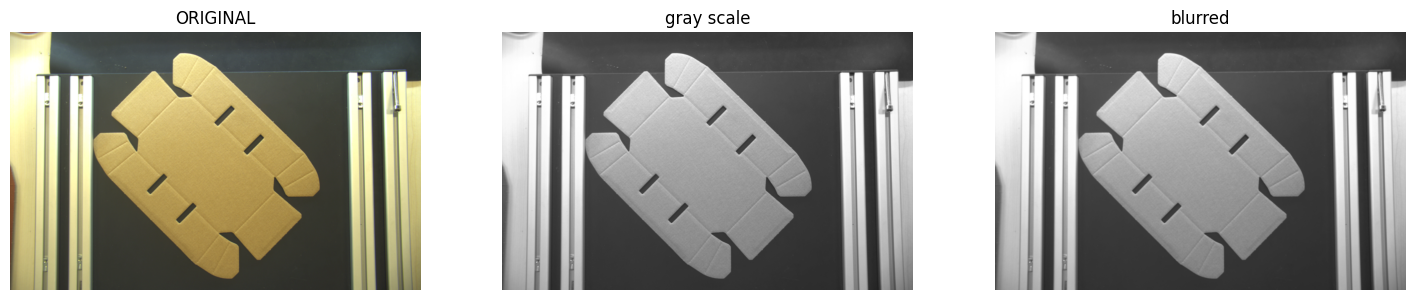

In [4]:
plt.figure(figsize=(18, 6))

plt.subplot(1,3,1)
plt.imshow(image_rgb, vmin=0, vmax=255)
plt.title("ORIGINAL")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gray, cmap="gray", vmin=0, vmax=255) # to complete
plt.title("gray scale")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(blurred, cmap="gray", vmin=0, vmax=255) # to complete
plt.title("blurred")
plt.axis("off")

# Threshold

In [5]:
# THRESHOLD
thValue = 110
_ , thBIN = cv.threshold(blurred,thValue,255,cv.THRESH_BINARY)
_ , thBININV = cv.threshold(blurred,thValue,255,cv.THRESH_BINARY_INV)
_ , thTOZERO = cv.threshold(blurred,thValue,255,cv.THRESH_TOZERO)
_ , thTOZEROINV = cv.threshold(blurred,thValue,255,cv.THRESH_TOZERO_INV)
_ , thTRUNC = cv.threshold(blurred,thValue,255,cv.THRESH_TRUNC)


(np.float64(-0.5), np.float64(1935.5), np.float64(1215.5), np.float64(-0.5))

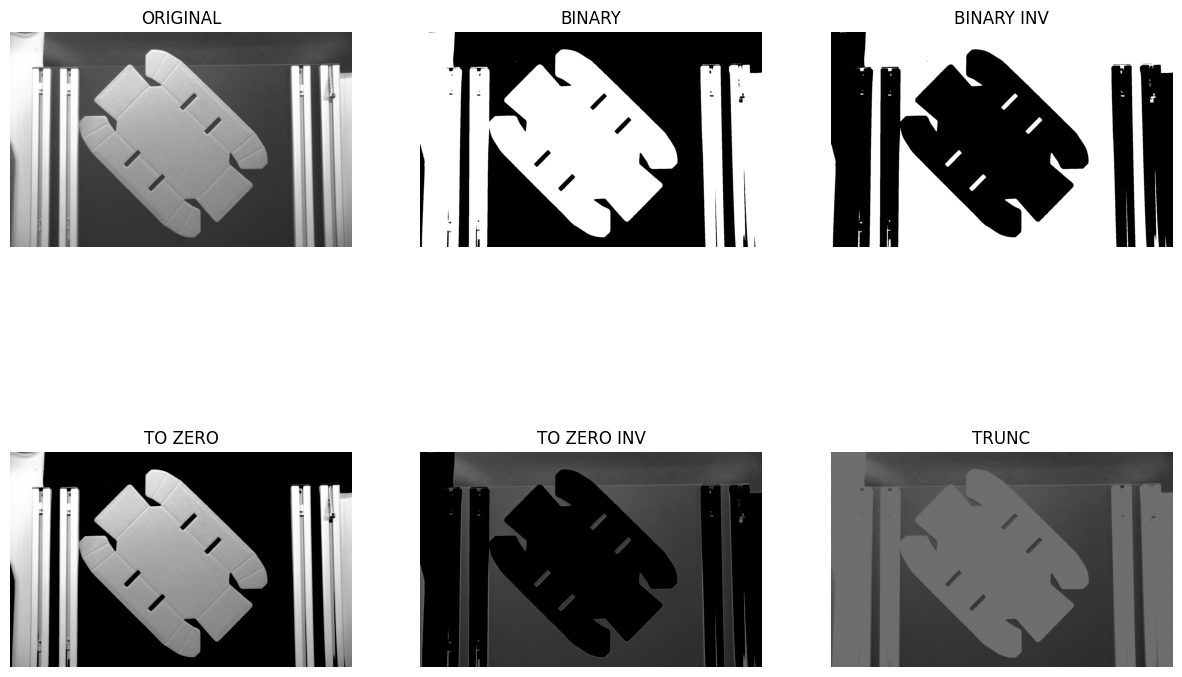

In [6]:
# PLOT IMAGES

plt.figure(figsize=(15, 10))

plt.subplot(2,3,1)
plt.imshow(blurred, cmap="gray", vmin=0, vmax=255)
plt.title("ORIGINAL")
plt.axis("off")

plt.subplot(2,3,2)
plt.imshow(thBIN, cmap="gray", vmin=0, vmax=255) # to complete
plt.title("BINARY")
plt.axis("off")

plt.subplot(2,3,3)
plt.imshow(thBININV, cmap="gray", vmin=0, vmax=255) # to complete
plt.title("BINARY INV")
plt.axis("off")

plt.subplot(2,3,4)
plt.imshow(thTOZERO, cmap="gray", vmin=0, vmax=255) # to complete
plt.title("TO ZERO")
plt.axis("off")

plt.subplot(2,3,5)
plt.imshow(thTOZEROINV, cmap="gray", vmin=0, vmax=255) # to complete
plt.title("TO ZERO INV")
plt.axis("off")

plt.subplot(2,3,6)
plt.imshow(thTRUNC, cmap="gray", vmin=0, vmax=255) # to complete
plt.title("TRUNC")
plt.axis("off")

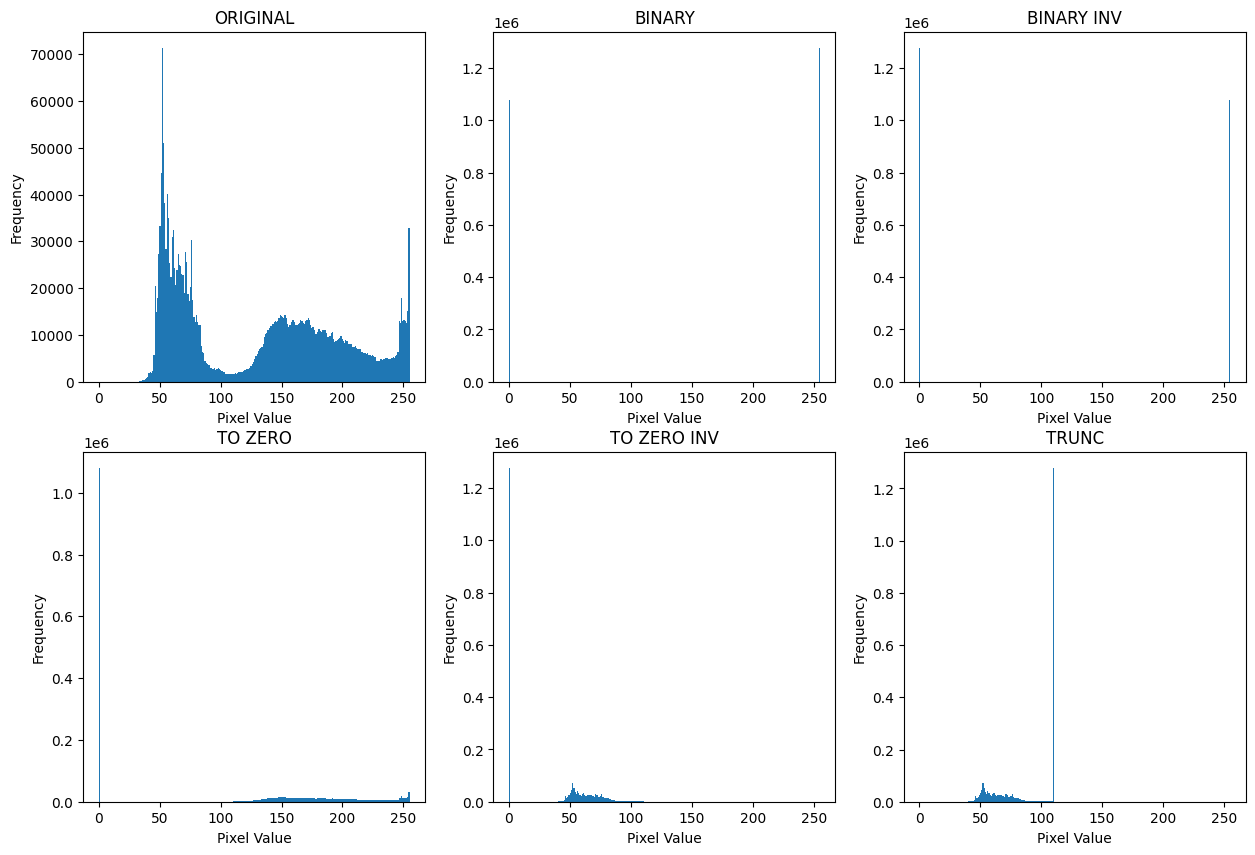

In [7]:
# PLOT HISTOGRAMS

plt.figure(figsize=(15, 10))  # Adjust figure size for better visibility

plt.subplot(2,3,1)
plt.hist(blurred.ravel(), bins=256, range=(0, 255))
plt.title("ORIGINAL")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.subplot(2,3,2)
plt.hist(thBIN.ravel(), bins=256, range=(0, 255)) # to complete
plt.title("BINARY")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.subplot(2,3,3)
plt.hist(thBININV.ravel(), bins=256, range=(0, 255)) # to complete
plt.title("BINARY INV")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.subplot(2,3,4)
plt.hist(thTOZERO.ravel(), bins=256, range=(0, 255)) # to complete
plt.title("TO ZERO")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.subplot(2,3,5)
plt.hist(thTOZEROINV.ravel(), bins=256, range=(0, 255)) # to complete
plt.title("TO ZERO INV")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.subplot(2,3,6)
plt.hist(thTRUNC.ravel(), bins=256, range=(0, 255)) # to complete
plt.title("TRUNC")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

plt.show()

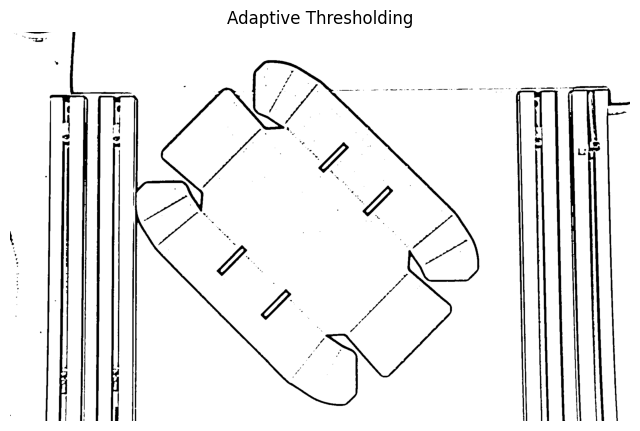

In [17]:
thresh = cv.adaptiveThreshold(
    blurred, 
    maxValue=255,
    adaptiveMethod=cv.ADAPTIVE_THRESH_GAUSSIAN_C,  # o MEAN_C
    thresholdType=cv.THRESH_BINARY,
    blockSize=31,  # debe ser impar y > 1
    C=8  # constante que se resta
)
kernel = np.ones((3, 3), np.uint8)
thresh_clean = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)

plt.figure(figsize=(8, 6))
plt.imshow(thresh_clean, cmap='gray')
plt.title("Adaptive Thresholding")
plt.axis('off')
plt.show()

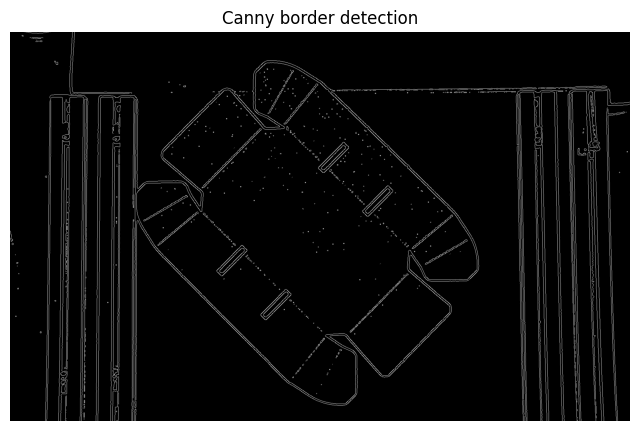

In [14]:
# Applying Canny edge detection
edges = cv.Canny(thresh_clean, threshold1=100, threshold2=120)

plt.figure(figsize=(8, 6))
plt.imshow(edges, cmap='gray')
plt.title("Canny border detection")
plt.axis('off')
plt.show()

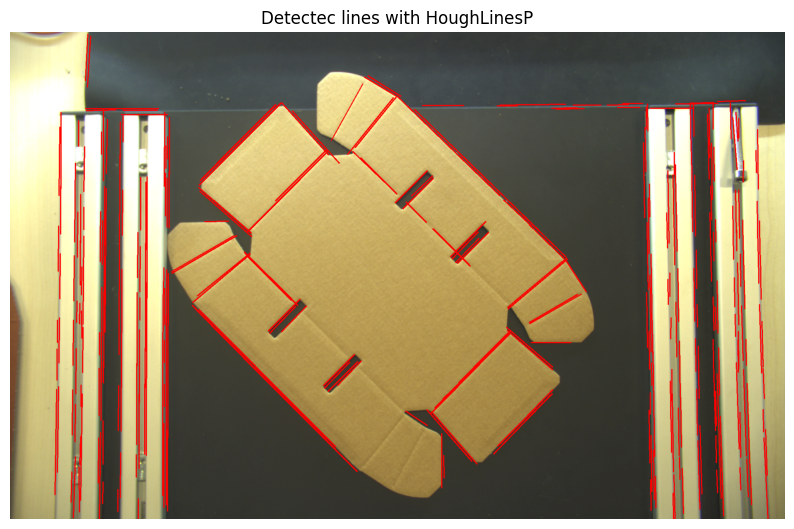

In [15]:
# HoughLinesP for line detection
lines = cv.HoughLinesP(
    edges,
    rho=1,
    theta=np.pi / 180,
    threshold=80,
    minLineLength=50,
    maxLineGap=10
)
# Draw lines on the original image
output = image.copy()
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv.line(output, (x1, y1), (x2, y2), (0, 0, 255), 2)

# Show the result
plt.figure(figsize=(10, 8))
plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
plt.title("Detectec lines with HoughLinesP")
plt.axis('off')
plt.show()